# Devoir 4 &mdash; Stéréo-vision et reconstruction 3D
## Récupération des fichiers dans Colab

In [1]:
#
# Exécutez cette cellule pour préparer votre environnement Colab.
#
# %%capture --no-stderr
# !wget https://benhadid.github.io/m1vpo/static_files/assignments/hw3.zip
# !unzip hw3.zip
# !mv hw3/* .
# !rm -rf hw3
# !rm -rf hw3.zip
# !pip install ipympl

## Initialisation des Widgets sous Colab

In [2]:

# from google.colab import output
# output.enable_custom_widget_manager()

ModuleNotFoundError: No module named 'google'

# 1. Description

L'un des principaux domaines de la Vision Par Ordinateur est la reconstruction 3D. Étant donné plusieurs images 2D d'une scène, comment récupérer la structure 3D de l'environnement, ainsi que la position de la caméra / du robot ? Cela a de nombreuses applications en robotique et en systèmes autonomes car la compréhension de la structure tridimensionnelle de l'environnement est cruciale pour la navigation.

<!---
<center>
<img src="figures/va_slam_full.png" style="width:70%"/>
<br>
<b>Figure 1</b>. Exemple d'un robot utilisant SLAM, un algorithme de reconstruction et de localisation 3D
</center>
--->

Dans ce devoir, il est demandé d'implémenter un ensemble de fonctions pour générer des cartes de profondeur 3D à partir d'une paire d'images stéréos.

<!--
<table><tr>
<td><img src="data/middlebury/2006/rflowerpots_left.png" /></td>
<td><img src="data/middlebury/2006/rflowerpots_right.png" /></td>
</tr></table>
-->
<!-- <center><b>Figure 1</b>. Images de synthèse</center> -->

De manière succinct, vous commencerez par écrire une fonction qui calcule la Matrice Fondamentale associée à une paire d'images appariées. Ensuite, vous implémenterez une fonction qui utilise cette matrice et les contraintes de « géométrie épipolaire » pour trouver plus de paires de correspondance entre les deux images. Enfin, vous coderez une fonction qui calcule les coordonnées 3D pour chacune de ces paires de points 2D.

Dans un second temps, et afin de réaliser une reconstruction 3D dense de la scène, vous implémenterez le code pour la rectification géométrique des images. Vous utiliserez, ensuite, la paire d’images rectifiées pour calculer des cartes denses de disparité et de profondeur.


# 2. Règles de codage

**<span style='color:Red'>
NE MODIFIEZ PAS LE CODE SQUELETTE EN DEHORS DES BLOCS TODO.<br>L'EVALUATEUR AUTOMATIQUE SERA TRES MECHANT AVEC VOUS SI VOUS LE FAITES !
</span>**

## 2.1. Résumé des fonctions potentiellement utiles (vous n'êtes pas obligé de les utiliser)  
- numpy.*
- scipy.signal.*
- scipy.ndimage.*

## 2.2. Résumé des fonctions <span style='color:Red'>interdites</span>

- cv2.findFundamentalMat, cv2.computeCorrespondEpilines, cv2.decomposeEssentialMat, cv2.convertPointsToHomogeneous,
- cv2.convertPointsFromHomogeneous, cv2.convertPointsHomogeneous, cv2.correctMatches, cv2.decomposeProjectionMatrix,
- cv2.solvePnP, cv2.solvePnPRansac, cv2.findHomography, cv2.initCameraMatrix2D, cv2.projectPoints, cv2.RQDecomp3x3,
- cv2.StereoBM_create, cv2.StereoSGBM_create, cv2.stereoCalibrate, cv2.StereoRectify, cv2.stereoRectifyUncalibrated,
- cv2.triangulatePoints, cv2.calibrateCamera, cv2.getOptimalNewCameraMatrix, scipy.linalg.rq,
- cv2.sfm.\*, skimage.feature.\*, skimage.measure.\*, skimage.transform.\*

Vous pouvez utiliser ces fonctions pour le débogage de votre code, mais la version finale ne doit en aucun cas les inclure faute d'avoir un zéro pour le devoir.

# 3. Initialisation et paramétrage du bloc-notes
## 3.1. chargement des modules python

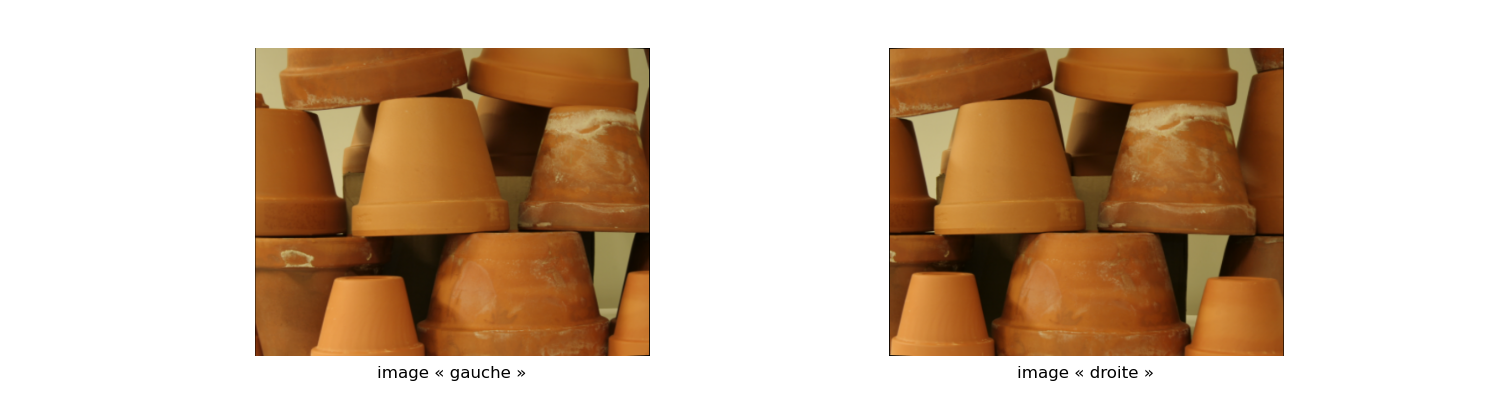

In [1]:
# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import numpy.linalg as la
%matplotlib widget
import matplotlib.pyplot as plt
import cv2

from utils import plot_matches

## Commençant par charger deux images

def read_image(path):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    return img

# middlebury_2006
img1filename    = 'data/rflowerpots_left.png'
img2filename    = 'data/rflowerpots_right.png'
principal_point = (437/2., 370/2.)
focal_distance  = (1247,1247)
base_distance   = 160/0.005
max_disparity   = 70
dmin = 251.

I1 = read_image(img1filename)
I2 = read_image(img2filename)

plt.rcParams['figure.figsize'] = (15, 4) # set default size of plots
#plt.rcParams['image.interpolation'] = 'nearest'
#plt.rcParams['image.cmap'] = 'gray'

fig, [ax_l, ax_r] = plt.subplots(1, 2)
# Hide the Figure name at the top of the figure
fig.canvas.header_visible = False
# Hide the footer
fig.canvas.footer_visible = False

ax_l.imshow(I1, cmap='gray')
ax_l.set_title('image « gauche »', y=-0.10)
ax_l.set_axis_off()

ax_r.imshow(I2, cmap='gray')
ax_r.set_title('image « droite »', y=-0.10)
ax_r.set_axis_off()

## 3.2. Calcul des points-clés et correspondances
Commençons par determiner et associer les points-clés dans les deux images.

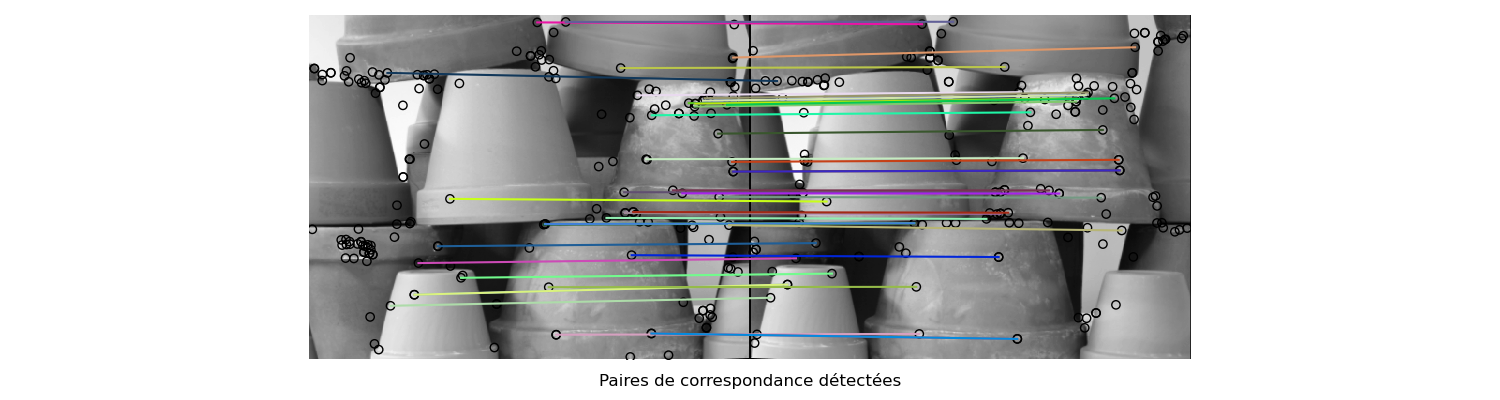

In [2]:
# construisons l'objet sift pour la detection et la description
# des points clés
sift = cv2.SIFT_create(nfeatures=2000)

# détection des points-clés et construction des
# descripteurs associés
keypoints_list   = []  # keypoints[i] corresponds to imgs[i]
descriptors_list = []  # descriptors[i] corresponds to keypoints[i]

for img in [I1, I2]:
    # trouver les points-clés et leurs descripteurs
    keypoints, descriptors = sift.detectAndCompute(img, None)

    keypoints_list.append(keypoints)
    descriptors_list.append(descriptors)


# comparaison des descripteurs et détection
# des correspondances
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params,search_params)

# matches_list[i] décrit la paire de correspondance entre
# les descripteurs descriptors[i] et descriptors[i+1]
matches_list = []
threshold = 0.5    # 0.5 (stringent), 0.7 (balanced), 0.9 (relaxed)
for pair in zip(descriptors_list[:-1], descriptors_list[1:]):
    matches = flann.knnMatch(pair[0], pair[1], k=2)

    good_match = []
    for m,n in matches:
        if m.distance < threshold * n.distance:
            good_match.append(m)

    matches_list.append(good_match)

# Pour ce devoir de stereo-vision, nous utiliserons les paires de
# correspondance dans matches_list[0] (entre img[0] et img[1]).
# Extraction de la liste des correspondances à partir des structures
# de données OpenCV
matches = np.array([ (m.queryIdx, m.trainIdx) for m in matches_list[0] ])

# visualisation des correspondances...
#
fig, ax = plt.subplots(1, 1)
# Hide the Figure name at the top of the figure
fig.canvas.header_visible = False
# Hide the footer
fig.canvas.footer_visible = False
# Hide the axes
ax.axis('off')

#traçage...
plot_matches(ax, I1, I2, keypoints_list[0], keypoints_list[1], matches,
                 keypoints_color='k', matches_color=None, only_matches=False)
plt.title('Paires de correspondance détectées', y=-0.10)
plt.tight_layout()
plt.show()

# 4. Les tâches

## 4.1. Calcul de la matrice Fondamentale

La matrice Fondamentale, notée $\mathbf{F}$, est une matrice $3\times 3$ (de rang 2) qui relie l'ensemble de correspondance de points dans deux images (stéréo) selon les contraintes de « géométrie épipolaire ». La géométrie épipolaire est la géométrie projective *intrinsèque* entre deux vues. Elle dépend uniquement des paramètres internes des caméras (matrice $\mathbf{K}$) et de la pose relative de ces dernières, c'est-à-dire qu'elle est **indépendante de la structure de la scène 3D**.


La matrice $\mathbf{F}$ est une représentation algébrique de la géométrie épipolaire et vérifie la contrainte ${\mathbf{x}'_i}^T \,  \mathbf{F}\, \mathbf{x}_i = 0$ où $\mathbf{x}_i$ et $\mathbf{x}'_i$ représentent $m$ points correspondants dans deux images ($i = 1, 2, \cdots, m$). Ceci est connu sous le nom de « contrainte épipolaire » ou « condition de correspondance » ou encore « équation de **Longuet-Higgins** ». sous forme matricielle, la contrainte épipolaire s'écrit :

$$
\begin{bmatrix}
x'_i & y'_i & 1
\end{bmatrix}
\,
\begin{bmatrix}
f_{11} & f_{12} & f_{13} \\
f_{21} & f_{22} & f_{23} \\
f_{31} & f_{32} & f_{33}
\end{bmatrix}
\,
\begin{bmatrix}
x_i \\
y_i \\
1
\end{bmatrix}
\,
= 0
$$

ainsi,

$$
x_i x'_i f_{11} + y_i x'_i f_{12} +  x'_i f_{13} + x_i y'_i f_{21} + y_i y'_i f_{22} + y'_i f_{23} + x_i f_{31} + y_i f_{32} + f_{33}=0. \qquad (*)
$$

Pour $m$ correspondances, cela donne

$$
\begin{bmatrix}
x_1 x'_1 & y_1 x'_1 &  x'_1 & x_1 y'_1 & y_1 y'_1 & y'_1 & x_1 & y_1 & 1 \\
\vdots  & \vdots  & \vdots  & \vdots  & \vdots  & \vdots  & \vdots  & \vdots  & \vdots \\
x_m x'_m & y_m x'_m &  x'_m & x_m y'_m & y_m y'_m & y'_m & x_m & y_m & 1 \\
\end{bmatrix}
\,
\begin{bmatrix}
f_{11} \\
f_{12} \\
f_{13} \\
f_{21} \\
f_{22} \\
f_{23} \\
f_{31} \\
f_{32} \\
f_{33}
\end{bmatrix}
\,
= 0
$$

De combien de points avons-nous besoin pour résoudre le système d'équations ci-dessus ? Contrairement à l'homographie, chaque paire de points correspondants ne contribue qu'à une seule équation (la contrainte épipolaire est un scalaire) dans l'estimation de la matrice $\mathbf{F}$. De plus, la matrice Fondamentale n'est définie qu'à un facteur d'échelle près et n'a donc que huit (et non neuf) degrés de liberté. Par conséquent, nous avons besoin de huit correspondances pour résoudre le système homogène ci-dessus, d'où le nom d'algorithme « [Huit-points](https://en.wikipedia.org/wiki/Eight-point_algorithm) ». Avec $N > 8$ correspondances entre deux images, nous pouvons empiler l'équation $(*)$ pour constituer un système surdéterminé $\mathbf{A} \; \mathbf{x} = \mathbf{0}$. Ce système peut être résolu en utilisant la méthode des « moindres carrés ».

**Tâche 4.1 (5 points) :** Implémentez dans le fichier `stereo.py` la fonction avec la signature suivante :

<p><center><code>F = eight_points(pts1, pts2)</code></center></p>

Cette fonction doit implémenter l'algorithme « Huit-points » pour estimer la matrice Fondamentale à partir d'un ensemble de points appariés. `pts1` et `pts2` sont des tableaux `N x 2` qui contiennent les coordonnées $(x_i,y_i)$ et $(x'_i,y'_i)$ des point-clés correspondants. Votre code doit implémenter une solution à un système surdéterminé (C.-à-d. supposez que $N > 8$).

Voici les étapes à réaliser :

- Normalisation et denormalisation de la matrice $\mathbf{F}$ : Une implementation naïve de l'algorithme « Huit-points » est sensible au problème de [conditionnement numérique](https://fr.wikipedia.org/wiki/Conditionnement_(analyse_num%C3%A9rique)) à cause de la variance trop importante dans les coordonnées des correspondances ponctuelles. Afin de tenir compte de ce problème, il est nécessaire de **normaliser** les coordonnées des points appariés avant de les utiliser dans le calcul de la matrice Fondamentale. Cette étape est réalisée en appliquant des transformations linéaires sur ces points afin que leurs magnitudes soient approximativement égales à 1.0 ou un autre petit nombre ( $\sqrt{2}$ est également [recommandée](https://en.wikipedia.org/wiki/Eight-point_algorithm) ). En gros, pour chaque image, nous calculons le barycentre (c.-à-d. moyenne des coordonnées) des points-clés et le soustrayons de chacun de ces points. Ensuite, une mise à l'échelle est appliquée aux points *centrés* de sorte que l'écart-type soit égale à √2 :

  $$
  \mathbf{p}'_i = \left( \mathbf{p}_i - \bar{\mathbf{p}} \right) \times  \frac{\sqrt{2}}{ \sigma_{\mathbf{p} }}  
  $$

  où $\bar{\mathbf{p}}$ est la moyenne des coordonnées des points $\mathbf{p}_i$ détectés dans l'image, et $\sigma_{\mathbf{p}}$ est [l'écart-type](https://fr.wikipedia.org/wiki/%C3%89cart_type) de ces points. Sous forme matricielle, cela donne :

  $$
  \begin{bmatrix}
  u' \\
  v' \\
  1
  \end{bmatrix}
  =
  \underbrace{
  \begin{bmatrix}
  s  &  0  &  0 \\
  0  &  s  &  0 \\
  0  &  0  &  1
  \end{bmatrix}
  \begin{bmatrix}
  1  &  0  &  -c_u \\
  0  &  1  &  -c_v \\
  0  &  0  &  1
  \end{bmatrix}
  }_{\mathbf{T}}
  \begin{bmatrix}
  u \\
  v \\
  1
  \end{bmatrix}
  $$
  
  avec : $\mathbf{p}'_i =\left[u',v',1\right]^T$, $\mathbf{p}_i=\left[u,v,1\right]^T$, $\bar{\mathbf{p}} = \left[c_u, c_v, 1\right]$ et $s= \sqrt{2} \bigg/ \sigma_{\mathbf{p}}$

  La matrice de transformation $\mathbf{T}$ est le produit de matrices de changement d'échelle et de translation. Une fois les coordonnées normalisées, nous procéderons à l'estimation de la matrice Fondamentale normée, notée $\mathbf{F_{norm}}$, à l'aide de l'algorithme « Huit-points ». Enfin, la matrice Fondamentale $\mathbf{F}$ est récupérée à partir de la matrice $\mathbf{F_{norm}}$ comme suit :

  $$
  \mathbf{F} = \mathbf{T}^T_2~\mathbf{F}_{norm}~\mathbf{T}_1
  $$


- Rappelons qu'une matrice Fondamentale $\mathbf{F}$ valide est celle où toutes les lignes épipolaires se croisent en **un seul** point. Mathématiquement, cela signifie qu'il existe un espace nul non trivial associé à $\mathbf{F}$ (c.-à-d. $rang(F) = 2$). En général, et à cause d’imprécisions numériques dans le calcul des correspondances de points, l’algorithme « huit-points » produira une matrice $\mathbf{F}$ qui ne vérifie pas cette condition. Pour régler ce problème, décomposez la matrice $\mathbf{F}$ en valeurs singulières pour obtenir les trois matrices $\mathbf{U}$, $\mathbf{\Sigma}$, $\mathbf{V}$ tel que $\mathbf{F} = \mathbf{U}~\mathbf{\Sigma}~\mathbf{V}^T$. Convertissez ensuite la matrice $\mathbf{\Sigma}$ en une autre matrice $\mathbf{\Sigma}'$ de rang égal à 2 en annulant la plus petite valeur singulière dans $\mathbf{\Sigma}$. Enfin, calculez la matrice Fondamentale rectifiée : $\mathbf{F}' = \mathbf{U}~\mathbf{\Sigma}'~ \mathbf{V}^T$.

  **Remarque :** La contrainte de « $rang(\mathbf{F})=2$ » doit être appliquée à la matrice Fondamentale normalisée $\mathbf{F}_{norm}$  (c.-à-d. **<ins>avant</ins>** la dénormalisation ).

In [ ]:
from stereo import eight_points
from utils import DisplayEpipolarLine

pts1 = np.squeeze( np.array( [ keypoints_list[0][ m[0] ].pt  for m in matches ] ) )
pts2 = np.squeeze( np.array( [ keypoints_list[1][ m[1] ].pt  for m in matches ] ) )

F = eight_points(pts1, pts2)

# Visualisation des lignes épipolaires ( matrice F et géométrie épipolaire incorrectes )
dep = DisplayEpipolarLine(I1, I2, F, showEpiLines=True)

## 4.2. Rejet des correspondances aberrantes via RANSAC

Dans §3.2, les correspondances de points sont calculées à l'aide d'un descripteur de caractéristiques (ici, SIFT). En général, les résultats retournés par la mise-en-correspondance de ce genre de descripteurs (ici, `FlannBasedMatcher`) sont bruitées et contiennent plusieurs correspondances aberrantes. Ceux-ci impactent négativement le calcul de la matrice Fondamentale à l'aide de l'algorithme « Huit-points ». Ainsi, pour supprimer ces valeurs dans le calcul de la matrice Fondamentale, nous utiliserons RANSAC (Oui ! Le même algorithme utilisé dans l'assemblage de Panoramas !)

Les étapes à effectuer par l'algorithme RANSAC sont énumérés comme suit :
1. Sélectionner, d'une manière aléatoire, un sous-ensemble de points (c.-à-d. huit paires) dans l'ensemble des correspondances $C$.   
2. Calculer une estimation de la matrice Fondamentale $\hat{\mathbf{F}}$ à partir du sous-ensemble sélectionné.
3. Appliquer la contrainte épipolaire  ${\mathbf{x}'_i}^T \,  \hat{\mathbf{F}}\, \mathbf{x}_i = 0 $ à l'ensemble complémentaire $\bar{C}$ et determiner les bonnes correspondances (*remarque* : Comme il s'agit d'opérations en virgule flottante, un seuil $\epsilon$ devrait plutôt être utilisé pour la comparaison).
4. Répéter les étapes 1&ndash;3 plusieurs fois et conserver la matrice  $\hat{\mathbf{F}}$ qui produit le plus grand nombre de bonnes correspondances.
5. Recalculer une meilleure estimation de la matrice $\hat{\mathbf{F}}$ en utilisant que les paires de points-clés classées comme « bonnes correspondances » (c.-à-d. les 'inliers').

**Tâche 4.2 (5 points) :** Implémentez dans le fichier `stereo.py` la fonction avec la signature suivante :

<p><center><code>F, robust_matches  = ransac(pts1, pts2, matches, n_ters=500, threshold=1e-4)</code></center></p>

`pts1` et `pts2` sont des tableaux `M1 x 2` et `M2 x 2` qui contiennent les coordonnées $(x_i,y_i)$ et $(x'_i,y'_i)$ des point-clés dans les deux images. `matches` est un tableau `N x 2` où chaque rangée représente une correspondance `[indice_dans_pts1, indice_dans_pts2]`. `niters` est le nombre d'iterations à effectuer, et enfin `threshold` est notre seuil $\epsilon$ mentionné dans l'étape 3.


In [ ]:
from stereo import ransac

# 1. récupérer les coordonnées des points clés depuis les structures opencv
pts1 = np.squeeze( np.array( [  kp.pt  for kp in keypoints_list[0] ] ) )
pts2 = np.squeeze( np.array( [  kp.pt  for kp in keypoints_list[1] ] ) )

# 2. Exécution de la fonction 'eight_points' (dans ransac) pour calculer la matrice fondamentale F.
F, robust_matches  = ransac(pts1, pts2, matches, threshold=1e-3)

# 3. récupération des coordonnées des "bonnes" correspondances
pts1 = np.squeeze( np.array( [ keypoints_list[0][ m[0] ].pt  for m in robust_matches ] ) )
pts2 = np.squeeze( np.array( [ keypoints_list[1][ m[1] ].pt  for m in robust_matches ] ) )

# traçons les correspondances...
fig, ax = plt.subplots(1, 1)
# Hide the Figure name at the top of the figure
fig.canvas.header_visible = False
# Hide the footer
fig.canvas.footer_visible = False

ax.axis('off')

plot_matches(ax, I1, I2, keypoints_list[0], keypoints_list[1], robust_matches,
                 keypoints_color='k', matches_color=None, only_matches=False)
plt.title('Paires de correspondance robustes (via RANSAC)', y=-0.10)
plt.tight_layout()
plt.show()

Pour visualiser / vérifier votre estimation de la matrice $\mathbf{F}$, exécutez le code ci-dessous. C'est un « widget » interactif ! C.-à-d. Vous pouvez sélectionner un point dans l'image de gauche et visualiser la ligne épipolaire correspondante dans l'image de droite.

In [ ]:
# Visualisation des lignes epipolaires (matrice F calculée à partir de bonnes correspondances seulement)
dep = DisplayEpipolarLine(I1, I2, F)

## 4.3. Correspondances épipolaires

Pour reconstruire une scène 3D depuis une paire d'images stéréo, nous devons trouver de nombreuses correspondances de points entre les images. Une paire de correspondance associe les coordonnées de deux points qui soient des projections sur les deux images du même point 3D (Figure 1). Avec un nombre suffisant de ces points, il est possible de visualiser un aperçu approximatif de la structure tridimensionnelle de la scène.

<center>
<img src="https://github.com/benhadid/m1vpo/blob/gh-pages/static_files/assignments/figs/epipolargeo.jpg?raw=1" width="40%"/>
<br>
<b>Figure 1</b>. Géométrie épipolaire</center>

Dans vos devoirs précédents, il était question d'apparier des paires de points à l'aide de descripteurs de primitives où chaque point détecté dans la première image est comparé à l'ensemble des points dans l'autre image. Ici, nous pouvons utiliser la contrainte imposée par la géométrie &laquo; épipolaire &raquo; pour simplifier considérablement cette tâche :

Étant donné un point $p_l$ dans une image (la vue de gauche dans Figure 4), le point correspondant $P$ dans la scène 3D pourrait se situer n'importe où le long de la ligne définie par le centre de la caméra $O_l$ et le point $p_l$. Cette ligne, avec le concours d'une deuxième ligne qui traverse les centres $O_l$ et $O_r$ des deux caméras forment un plan 3D (Figure 1). Ce plan intersecte avec le plan image de la deuxième caméra en une ligne $l_r$ appelée « ligne épipolaire ». Cette ligne décrit tous les emplacements possibles que $p_r$ pourrait avoir (c.-à-d. la projection de $P$ dans la deuxième image). Il suffit donc, de chercher le long de cette ligne pour trouver une correspondance possible pour le point $p_l$ dans la première image. Mathématiquement, les paramètres de la ligne epipolaire $l_r$ associé au point $p_l$ peuvent être calculés avec l'equation

$$
l_ r = \mathbf{F} p_l
$$

où $\mathbf{F}$ est la matrice Fondamentale associée aux images $I_l$ et $I_r$.


**Tâche 4.3 (20 points) :** Dans le fichier `stereo.py`, implémentez la fonction avec la signature suivante :

<p><center><code>pts2 = epipolar_match(I1, I2, F, pts1)</code></center></p>


où `I1` et `I2` sont les deux images de la paire stéréo, `F` est la matrice Fondamentale estimée avec votre fonction `ransac()`. `pts1` est un tableau `N x 2` contenant les coordonnées $\left(x, y\right)$ de points dans la première image. La fonction doit retourner `pts2`, un tableau `N x 2` qui contient les points correspondants dans la deuxième image. Voici les étapes à réaliser :

- Pour chercher une correspondance possible pour un point $p_l$ dans l'image $I_2$, utilisez la matrice Fondamentale pour estimer la ligne épipolaire associée $l_r$ et générer "un ensemble de points" candidats dans la deuxième image.

- Pour chaque point candidat $p_c$, calculez un score de similitude entre $p_l$ et $p_c$. Le point parmi les candidats avec le score le plus élevé sera considéré comme une correspondance épipolaire $p_r$.

- Il existe plusieurs façons de définir ce score. Une solution possible consiste à sélectionner une petite fenêtre de taille $W$ (par exemple $7 \times 7$) autour du point $p_l$ et comparer ensuite les pixels dans cette fenêtre aux pixels de la fenêtre associée au point candidat $p_c$. Pour les images fournies, une simple distance euclidienne après normalisation photométrique des fenêtres devraient suffire (c.f. « invariance  photométrique » du descripteur MOPS dans le cours « [descripteurs](https://benhadid.github.io/m1vpo/lectures/) »).

Une fois la fonction `epipolar_match()` implémentée, exécutez le code ci-dessous pour tester *visuellement* la fonction `epipolar_match()`. Votre implémentation n'a pas besoin d'être "parfaite", mais elle devrait correctement détecter la plupart des points faciles, comme les coins, les points singuliers, etc (voir Figure 2).

In [ ]:
# Visualisation des lignes epipolaires et les coordonnées des points appariés
# la fonction 'epipolar_match()' doit être implémentée avant d'exécuter cette cellule
depsm = DisplayEpipolarLine(I1, I2, F, showMatch=True)

## 4.4. Estimation de la « pose » du système stéréo

Étant donné une matrice essentielle $\mathbf{E}$, il est possible de récupérer l'orientation $\mathbf{R}$ et la translation $\mathbf {t}$ entre les systèmes de coordonnées des deux caméras (c.-à-d. la pose relative des caméras). En effet, rappelons l'expression

$$
\mathbf{E} =  \left[\,  \mathbf{t} \, \right] _\times \, \mathbf{R}
$$

où $\mathbf{R}$ est une matrice de rotation $3 \times 3$ et $\mathbf{t}$ est un vecteur de translation tridimensionnel. $\left[\, \mathbf{t} \, \right] _\times$ est la représentation matricielle du produit vectoriel avec ${\mathbf{t}}$. En utilisant la décomposition en valeurs singulières (c.-à-d. la SVD) de la matrice essentielle $\mathbf{E}$, il est possible de calculer une expression pour $\mathbf{R}$ et $ \left[\, \mathbf{t} \, \right ] _\times$ comme suit :

$$
\left[\,  \mathbf{t} \, \right] _\times = k\, \mathbf{U}\, \mathbf{Z}\, \mathbf{U}^T
\quad \text{et} \quad
\mathbf{R}  = \mathbf{U}\, \mathbf{W} \, \mathbf{V}^T  \,\text{ ou  }\,  \mathbf{U} \, \mathbf{W}^T \, \mathbf{V}^T
$$

où $\mathbf{U}$ et $\mathbf{V}$ sont des matrices $3 \times 3$ associées à la décomposition en valeurs singulières $\mathbf{U}\, \mathbf{D}\, \mathbf{V}^ T \stackrel{\text{svd}}{=}\mathbf{E}$. $k$ est un facteur d'échelle (c.-à-d. une constante), $\mathbf{W}$ et $\mathbf{Z}$ sont des matrices $3 \times 3$ définies comme suit :

$$
\mathbf{W} =
\begin{bmatrix}
 0  & -1  &  0 \\
 1  &  0  &  0 \\
 0  &  0  &  1
\end{bmatrix}
\quad \text{et}\quad
\mathbf{Z} =
\begin{bmatrix}
 0  &  1  &  0 \\
-1  &  0  &  0 \\
 0  &  0  &  0
\end{bmatrix}
.
$$

Pour résumer, étant donné $\mathbf{E}$ il y a deux directions opposées possibles pour $\mathbf{t}$ (puisque $k$ est une constante **signée**) et deux rotations différentes qui sont compatibles avec cette matrice Essentielle. Au total, cela donne quatre classes de solutions pour la rotation et la translation entre les deux systèmes de coordonnées des caméras.

Il s'avère cependant qu'une seule des quatre classes de solutions peut être réalisée en pratique. En effet, Étant donné un ensemble de correspondances valides entre les deux caméras, trois des solutions produiront toujours des points 3D qui se trouveront derrière au moins une des deux caméras et ne peuvent donc pas être "observés". Une seule configuration $\left[\mathbf{R}\,|\,\mathbf{t}\right]$ parmi les quatre classes produira systématiquement des points 3D devant les deux caméras. Cependant, il y'aura toujours un facteur positif indéterminé  $\left| k \right|$ associé au vecteur de translation $\mathbf{t}$.

<center>
<img src="https://github.com/benhadid/m1vpo/blob/gh-pages/static_files/assignments/figs/camera_pose.png?raw=1" style="width:100%"/>
<br>
<b>Figure 2</b>. configurations possibles des cameras</center>


Donc, nous avons besoin de la matrice Essentielle $\mathbf{E}$ pour déterminer la pose relative des caméras $\left[ \mathbf{R}, \mathbf{t}\right]$, mais comment obtenir $\mathbf{E}$ en premier lieu ? La matrice Essentielle $\mathbf{E}$ peut être considérée comme un précurseur de la matrice Fondamentale $\mathbf{F}$. En fait, les deux matrices sont liées par l'équation ci-dessous :

$$
\mathbf{E} = \mathbf{K}^{-T}_2 \, \mathbf{F} \, \mathbf{K}^{-1}_1
$$

où $\mathbf{K}_1$ et $\mathbf{K}_2$ sont des matrices $3 \times 3$ codant respectivement les paramètres intrinsèques associés aux première et seconde caméras.

Il est possible d'estimer les paramètres intrinsèques à partir des images (cf. cours [
« Étalonnage de caméra](https://adminunivalger-my.sharepoint.com/:p:/g/personal/a_benhadid_univ-alger_dz/EftUlCHrnIROvLY6xfBjEzkBfWel2BrCOqNytEAOv0xpog?e=e2ci2z%20%0A%20%20%20%20) »). Ici, cependant, nous supposerons que ceux-ci sont déjà à portée de main (et les mêmes pour les deux caméras)  :

- dimensions du capteur = 437 x 370 pixels
- distance focale = (1247, 1247) pixels
- distance entre les centres optiques (c.-à-d. dimension de la ligne de base) : 32000 pixels


**Tâche 4.4 (15 points) :** Implémentez dans le fichier `stereo.py` la fonction avec la signature suivante :

<p><center><code>K, Rt_list = estimate_camera_pose( F, sensor_size, focal_distance, base_distance )</code></center></p>

où `sensor_size` est un tuple `(hauteur,largeur)` indiquant les dimensions du capteur. `focal_length` est la distance focale (en pixels). `base_distance` est la distance (en pixels) entre les centres optiques. `F` est la matrice Fondamentale. Pour les valeurs retournées, nous avons : `K`, une matrice $3 \times 3$ qui codifie les paramètres intrinsèques des cameras, et `Rt_list` une liste contenant les quatre matrices $\left[\mathbf{R}_i|\mathbf{t}_i\right]$ de poses possibles.

*Indications :*  
1. Définissez la matrice $\mathbf{K}$ (la même pour les deux caméras) et utilisez-la pour calculer $\mathbf{E}$ à partir de $\mathbf{F}$.
2. Utilisez votre matrice $\mathbf{E}$ pour calculer et retourner les quatre matrices $ 3 \times 4 $ de poses possibles $\left[\mathbf{R}_i | \mathbf{t}_i \right]_{1 \leq i \leq 4}$ - l'ordre dans lequel les transformations sont renvoyées est sans importance.
3. Rappelons que le determinant d'une matrice de rotation est égale à 1. Donc, si &laquo; $\left|\mathbf{R}\right|=-1$ &raquo;, il faut corriger la pose de la caméra ( C.-à-d.  $\,\, \mathbf{R}_i \,:=\, -\mathbf{R}_i  $ ).

In [ ]:
from stereo import estimate_camera_pose
from utils import CameraPoseVisualizer

K, Rt_list = estimate_camera_pose( F, principal_point, focal_distance, base_distance )

cpv = CameraPoseVisualizer(Rt_list, scale=5000.0)

## 4.5. Condition de Chiralité et Triangulation

Dans la section précédente, nous avons calculé quatre poses de caméra possibles pour une paire d'images en utilisant la matrice Essentielle. Cependant, afin de trouver l'unique pose de caméra correcte, nous devons supprimer l'ambiguïté. Cela peut être accompli en vérifiant la « condition de chiralité », c'est-à-dire que les points reconstruits doivent être devant les caméras. Pour vérifier cette condition, nous avons besoin de « trianguler » les points 3D et vérifier le signe de la profondeur $Z$ de chaque point dans le système de coordonnées de la caméra. Un point 3D $\mathbf{X}$ est devant la caméra **ssi** : « $\mathbf{r}_3 \left( \mathbf{X} - \mathbf{t} \right) > 0$ » où $\mathbf{r}_3$ est la troisième ligne de la matrice de rotation (axe $\hat{z}$ de la caméra). En raison de la présence de bruit dans les correspondances établies, il pourrait y'avoir quelques points triangulés qui ne satisferont pas cette condition. La meilleure configuration de caméra, $\left[\mathbf{R}\, | \, \mathbf{t}\right]$ est celle qui produit le maximum de points satisfaisant la « condition de chiralité ».

<center>
<img src="https://github.com/benhadid/m1vpo/blob/gh-pages/static_files/assignments/figs/chirality.png?raw=1" style="width:100%"/>
<br>
<b>Figure 3</b>. condition de chiralité</center>


Selon le modèle sténopé, il existe une matrice de projection $\mathbf{P}_j = \mathbf{K}_j \, \left[ \mathbf{R}_j\,|\, \mathbf{t}_j\right] \in \mathbb{R}^{3 \times 4}$ associée à une caméra $j$ qui permet de calculer les coordonnées $\mathbf{x}_i$ qui soient les images (donc, projections) de points tridimensionels $\mathbf{X}_i$ :

$$
w_i
\begin{bmatrix}
\mathbf{x}_i \\
1
\end{bmatrix}
=
\mathbf{P}_j
\begin{bmatrix}
\mathbf{X}_i \\
1
\end{bmatrix}
.
$$

Etant donné deux matrices de projection $\mathbf{P}_0 = \mathbf{K}\, \left[ \mathbf{I} \, | \, \mathbf{0} \right] $ et $\mathbf{P}_j$ (une des quatres possibilités de configuration précédemment identifiées); et une paire de correspondance $\mathbf{x}\leftrightarrow \mathbf{x}'$ pour un point tridimensionnel $\mathbf{X}$. Nous aimerions retrouver les coordonnées 3D de ce point par un procédé appelé &laquo; triangulation &raquo;. Les slides du cours présentent ce processus pour le cas de caméras parallèles... ici, il est question d'implémenter un algorithme plus général. Nous avons :

$$
w  \mathbf{\tilde{x}}  = \mathbf{P}_0\,\mathbf{\tilde{X}},\quad
w' \mathbf{\tilde{x}}' = \mathbf{P}_j\,\mathbf{\tilde{X}},\quad \text{avec} \quad
\mathbf{\tilde{x}}=
\begin{bmatrix}
u\\
v\\
1
\end{bmatrix},\quad
\mathbf{\tilde{x}}'=
\begin{bmatrix}
u'\\
v'\\
1
\end{bmatrix},\quad
\mathbf{P}_j=
\begin{bmatrix}
\,\rule[.5ex]{3.5ex}{0.5pt} \,\, \mathbf{p}^j_1 \,\, \rule[.5ex]{3.5ex}{0.5pt} \, \\
\,\rule[.5ex]{3.5ex}{0.5pt} \,\, \mathbf{p}^j_2 \,\, \rule[.5ex]{3.5ex}{0.5pt} \, \\
\,\rule[.5ex]{3.5ex}{0.5pt} \,\, \mathbf{p}^j_3 \,\, \rule[.5ex]{3.5ex}{0.5pt} \,
\end{bmatrix}
,\quad  \mathbf{\tilde{X}} \in \mathbb{R}^4
$$


$w$ et $w'$ sont des constantes quelconques non nulles (rappelons que les matrices $\mathbf{P}_0$ et $\mathbf{P}_j$ sont définies à des facteurs multiplicatifs près). Ainsi, nous avons

$$
u  \,\, \mathbf{p}^0_3 \, \mathbf{\tilde{X}} = \, \mathbf{p}^0_1 \, \mathbf{\tilde{X}}\quad, \quad
u' \,\, \mathbf{p}^j_3 \, \mathbf{\tilde{X}} = \, \mathbf{p}^j_1 \, \mathbf{\tilde{X}} \\
v  \,\, \mathbf{p}^0_3 \, \mathbf{\tilde{X}} = \, \mathbf{p}^0_2 \, \mathbf{\tilde{X}}\quad , \quad
v' \,\, \mathbf{p}^j_3 \, \mathbf{\tilde{X}} = \, \mathbf{p}^j_2 \, \mathbf{\tilde{X}}
$$

sous forme matricielle, cela donne :

$$
\mathbf{D}\,\mathbf{\tilde{X}} = 0, \quad \text{avec }\,\,
\mathbf{D}=
\begin{bmatrix}
u  \,\, \mathbf{p}^0_3 \,\, - \, \mathbf{p}^0_1 \, \\
v  \,\, \mathbf{p}^0_3 \,\, - \, \mathbf{p}^0_2 \, \\
u' \,\, \mathbf{p}^j_3 \,\, - \, \mathbf{p}^j_1 \, \\
v' \,\, \mathbf{p}^j_3 \,\, - \, \mathbf{p}^j_2 \,
\end{bmatrix},\quad
\mathbf{D} \in \mathbb{R}^{4\times4}
$$

Le vecteur de coordonnées homogènes $\mathbf{\tilde{X}}$ représente donc un &laquo; vecteur singulier droit &raquo; associé à la matrice $\mathbf{D}$ et peut être obtenu par décomposition SVD de celle-ci. Il suffit ensuite de diviser le vecteur $\mathbf{\tilde{X}}$ par sa quatrième composante pour récupérer les coordonnées cartésiennes $\mathbf{X}$ du point 3D.

**Tâche 4.5-1 (10 points):** Implémentez dans le fichier `stereo.py` la fonction avec la signature suivante :

<p><center><code>pts3d = triangulate(P1, pts1, P2, pts2)</code></center></p>

Cette fonction doit calculer les coordonnées 3D à partir de paires de points 2D selon la méthode illustrée ci-dessus.
- `pts1` et `pts2` sont des tableaux `N x 2` contenant les coordonnées de points 2D dans les images I1 et I2,
- `P1` et `P2` sont les matrices de projection  `3 x 4` associées à ces images,
- `pts3d` est un tableau `N x 3` contenant les coordonnées 3D calculées.

**Tâche 4.5-2 (15 points):** Implémentez dans le fichier `stereo.py` la fonction avec la signature suivante :

<p><center><code>Rt, pts3d_list =  check_chirality(K, Rt_list, pts1, pts2)</code></center></p>

Cette fonction doit vérifier la « condition de chiralité » discutée ci-dessus afin de determiner la pose `Rt` corrècte parmi les quatre poses possibles fournies dans la liste `Rt_list`.
- `K` est la matrice `3 x 3` des paramètres intrinsèques du système stéréo retournée par la fonction `estimate_camera_pose()` dand la tâche 4.3.
- `Rt_list`est une liste de quatre matrices `3 x 4` (retournée également par la fonction `estimate_camera_pose()`).
- `pts1` et `pts2` sont des tableaux `N x 2` contenant les coordonnées de points 2D dans les images I1 et I2.
- `Rt` est la matrice de pose correcte retournée.
- `pts3d_list` est une liste de quatre matrices `N x 3` contenant les coordonnées 3D calculées à partir de chaque pose dans `Rt_list`

In [ ]:
from stereo import check_chirality

Rt, pts3d_list =  check_chirality(K, Rt_list, pts1, pts2)

cpvs = CameraPoseVisualizer(Rt_list, pts3d_list, scale=5000.0)

# 5. Rectification des images

Rappelons qu'un cas intéressant pour la géométrie épipolaire se produit lorsque deux images sont parallèles l'une à l'autre. En effet, dans ce cas, la direction de la ligne épipolaire $l$ dans la figure ... est horizontale, de même que la direction de $l'$. Si nous utilisons la contrainte épipolaire $\mathbf{p}'^T \, \mathbf{F} \, \mathbf{p} = 0$, où $\mathbf{p} = \left[x,y,1\right]^T$ et $\mathbf{p}'=\left[x',y',1\right]^T$ alors nous arriverons au fait que $y = y'$, démontrant que $\mathbf{p}$ et $\mathbf{p}'$ partagent **la même ordonnée verticale**. Ceci est très utile pour la recherche et identification des points correspondants dans les images.

**La rectification** est le processus qui rend parallèle deux images stéréo données. Rectifier une paire d'images ne nécessite pas de connaître les paramètres intrinsèques des caméras ou leur pose relative $\mathbf{R},\,\mathbf{t}$. Mais nous avons besoin de connaître la géométrie des lignes épipolaires et épipoles associés dans les deux images. Ces informations sont facilement récupérable à partir de la matrice Fondamentale liant les deux images.

En général, les ordonnées homogènes $w$ et $w'$ des épipoles $\mathbf{e}$ et $\mathbf{e}'$ dans la figure ... sont différentes de zéro. C-à-d. ce ne sont pas des points qui se situent à l'infini (le long de l'axe horizontal). S'ils l'étaient, alors, par définition, les images seraient déjà parallèles et aucune rectification n'est nécessaire. Ainsi, les coordonnées des épipoles nous donnent une indication sur la façon de rendre les images parallèles : Y'a-t-il une transformation Homographique qui permet de projeter un épipole $\mathbf{e}$ à l'infini le long de l'axe horizontal ? Concrètement, cela signifie que nous voulons trouver deux matrices d'homographies $\mathbf{H}$ et $\mathbf{H}'$ à appliquer aux deux images afin de projeter les épipoles $\mathbf{e}$ et $\mathbf{e}'$ à l'infini.

## 5.1. Rectification de l'image de droite  
Commençons par trouver une homographie $\mathbf{H}'$ qui envoie le second épipole $\mathbf{e}'$ à l'infini sur l'axe horizontal. Les coordonnées transformées de l'épipole devraient donc être de la forme $\left[f, 0, 0\right]^T$ où $f$ est une constante positive arbitraire. La première étape pour réaliser une telle transformation est de translater la deuxième image de sorte que le centre soit à la position $\left[0, 0, 1\right]^T$ en coordonnées homogènes. Nous pouvons effectuer cette tâche en appliquant la matrice de translation suivante

$$               
\mathbf{T} =
\begin{bmatrix}
1 & 0 & -c_x \\
0 & 1 & -c_y \\
0 & 0 & 1
\end{bmatrix}
$$

où $c_x$ et $c_y$ indiquent les coordonnées du point principal. Dans le cas où ce dernier n'est pas connu, nous pouvons utiliser l'approximation : $c_x = w / 2$ et $c_y = h / 2$, avec $w$ et $h$ étant, respectivement, les dimensions horizontale et verticale de l'image.

Après avoir appliqué la translation, nous effectuons une rotation pour placer l'épipole sur l'axe horizontal en un point $\left[f, 0, 1\right]^T$. Ainsi, si l'épipole translaté $\mathbf{T}\,\mathbf{e}'$ possède les coordonnées homogènes $\left[e'_1 , e'_2 , 1\right]^T$, alors la rotation à appliquer est

$$       
\mathbf{R} =
\begin{bmatrix}
 \alpha  \frac{e'_1}{ \sqrt{ {e'}^2_1 + {e'}^2_2 }}  &  \alpha \frac{e'_2}{ \sqrt{ {e'}^2_1 + {e'}^2_2 }}  &  0  \\
-\alpha  \frac{e'_2}{ \sqrt{ {e'}^2_1 + {e'}^2_2 }}  &  \alpha \frac{e'_1}{ \sqrt{ {e'}^2_1 + {e'}^2_2 }}  &  0  \\
                                         0  &                                           0  &  1
\end{bmatrix}
$$

où $\alpha = 1$ si $e'_1 \geq 0$ et $\alpha = −1$ autrement.

Après l'application de cette rotation, notons que, pour amener n'importe quel point $\left[f, 0, 1\right]^T$ à l'infini sur l'axe horizontal (c.-à-d. nullifier la composante $w$) il suffit d'appliquer la transformation
     
$$
\mathbf{G} =
\begin{bmatrix}
           1 & 0 & 0 \\
           0 & 1 & 0 \\
-\frac{1}{f} & 0 & 1
\end{bmatrix}
$$

Nous avons finalement un épipole à l'infini et nous pouvons donc appliquer une translation inverse  pour repositionner l'image dans l'espace ordinaire. Ainsi, pour rectifier la deuxième image, nous appliquerons la transformation d'homographie $\mathbf{H}'$ définit comme suit :

$$
\mathbf{H}' = \mathbf{T}^{-1}\, \mathbf{G}\, \mathbf{R}\, \mathbf{T}
$$

## 5.2. Rectification de l'image de gauche
Après avoir définit l'homographie $\mathbf{H}'$, nous devons trouver une homographie correspondante $\mathbf{H}$ pour la première image. En ce sens, nous avons besoin de trouver la transformation $\mathbf{H}$ qui minimise l'equation suivante :

$$
\DeclareMathOperator*{\argmin}{arg\,min}
\argmin_{\mathbf{H}} \sum_i \lVert \mathbf{H}\,\mathbf{p}_i -  \mathbf{H}'\,\mathbf{p}'_i  \rVert^2
\qquad \qquad \left(*\right)
$$

Le chapitre 11 du livre de Hartley & Zisserman «[Multiple View Geometry](https://benhadid.github.io/m1vpo/materials/) » donne plus de détail sur la dérivation de $(*)$. La matrice $\mathbf{H}$ correspondante est de la forme :

$$
\mathbf{H} = \mathbf{H}_\mathbf{A}\, \mathbf{H}' \, \mathbf{M}
$$

où

$$
\mathbf{M} = \left[\mathbf{e}\right]_\times \, \mathbf{F} + \mathbf{e}\, \mathbf{v}^T
$$

avec $\mathbf{v}^T = \left[1, 1, 1\right]$, et

$$
\mathbf{H}_\mathbf{A} =
\begin{bmatrix}
           a_0 & a_1 & a_2 \\
             0 & 1   & 0 \\
             0 & 0   & 1
\end{bmatrix}
$$

Pour trouver les coefficients $a_j$, rappelons que puisque nous connaissons déjà les valeurs de $\mathbf{H}'$ et $\mathbf{M}$, alors nous pouvons faire les substitutions $\mathbf{\hat{ p}}_i \triangleq \mathbf{H}'\,\mathbf{M}\,\mathbf{p}_i$ et $\mathbf{\hat{p}}'_i \triangleq \mathbf{H}'\, \mathbf{p}'_i$ dans $\left(*\right)$. Le problème de minimisation devient

$$
\DeclareMathOperator*{\argmin}{arg\,min}
\argmin_{\mathbf{H}_\mathbf{A}} \sum_i \lVert \mathbf{H}_\mathbf{A}\, \mathbf{\hat{ p}}_i -  \mathbf{\hat{p}}'_i  \rVert^2
$$

En particulier, si nous considérons les coordonnées $\left[\hat{x}_i , \hat{y}_i , 1\right]^T$ et $\left[\hat{x}'_i , \hat{y}'_i , 1\right]^T$ associées respectivement aux points $\mathbf{\hat{p}}_i$ et $\mathbf{\hat{ p}}'_i$, alors le problème de minimisation ci-dessus peut être remplacé par :

$$
\DeclareMathOperator*{\argmin}{arg\,min}
\argmin_{\mathbf{a}} \sum_i \left( a_0 \, \hat{x}_i + a_1 \, \hat{y}_i + a_2 - \hat{x}'_i \right)^2 + \left( \hat{y}_i - \hat{y}'_i\right)^2
$$

où $\mathbf{a}\triangleq \left[a_0, a_1, a_2\right]^T$ est un vecteur composé de trois coefficients à déterminer. Au fait, comme le terme $\sum_i \left( \hat{y}_i - \hat{y}'_i\right)^2$ ci-dessus ne dépend pas des coefficients $a_j$, le problème de minimisation se réduit davantage à la forme suivante

$$
\DeclareMathOperator*{\argmin}{arg\,min}
\argmin_{\mathbf{a}} \sum_i \left( a_0 \, \hat{x}_i + a_1 \, \hat{y}_i + a_2 - \hat{x}'_i \right)^2
$$

En fin de compte, pour trouver $\mathbf{a}$, cela nous ramène à la résolution d'un problème de moindres carrés de la forme  $\mathbf{W}\,\mathbf{a} = \mathbf{b}$ où :

$$
\mathbf{W} =
\begin{bmatrix}
\hat{x}_0 & \hat{y}_0 & 1 \\
& \vdots  &                  \\
\hat{x}_n & \hat{y}_n & 1
\end{bmatrix}
, \qquad
\mathbf{b} =
\begin{bmatrix}
\hat{x}'_0 \\
\vdots     \\
\hat{x}'_n  
\end{bmatrix}
$$

Après avoir calculé $\mathbf{a}$, nous pouvons déduire $\mathbf{H}_\mathbf{A}$, et par consequence la matrice d'homographie $\mathbf{H}$.

Veuillez notez que ce n'est pas l'unique façon de rectifier une paire d'images stéréos, les articles de [Loop and Zhang](https://drive.google.com/file/d/1x2DaxSAwOUVG8VORU5ZE1JRzW6aGYOLM/view?usp=sharing) et de [Fusiello et al.](https://drive.google.com/file/d/1KcuRbmFB0cnDslauxklznFkzrbq1TkT-/view?usp=sharing) présentent d'autres approches intéressantes.


**Tâche 5.X (15 points) :** Implémentez dans le fichier `stereo.py` la fonction avec la signature suivante :

<p><center><code>H1, H2 = compute_matching_homographies(F, principal_point, pts1, pts2)</code></center></p>

Cette fonction doit calculer les matrices (`3 x 3`) de rectification `H1` et `H2` pour les deux images. Elle prend en entrée :
 - la matrice Fondamentale `F` (`3 x 3`) du système stéréo,
 - les coordonnées du centre optique `principal_point` `(2 x 1)`,
 - deux tableaux `pts1` et `pts2` (`N x 2`) contenant les coordonnées de points 2D correspondants dans les images I1 et I2.

Une fois votre implémentation terminée, testez votre fonction en utilisant le script ci-dessous.

In [ ]:
from stereo import pad, unpad, compute_matching_homographies
from utils import _warpStereo

# 1. Rectify the images and save the parameters
H1, H2 = compute_matching_homographies(F, principal_point, pts1, pts2)

# 2. Reduce distortions (this is the third task in Loop and Zhang's paper)
h, w = I1.shape[:2]
##Consider the four midpoints of the image edges:
mid = np.array([[ (w-1)/2.0, 0.       ],    # a.T
                [ (w-1),     (h-1)/2. ],    # b.T
                [ (w-1)/2.0, (h-1)    ],    # c.T
                [ 0,         (h-1)/2. ]])   # d.T

H_list = [H1, H2]
for i, H in enumerate(H_list):

    midp = pad(mid).dot(H.T)                #  [a', b', c', d' ] =  H dot [a, b, c, d ]
    midp = midp / midp[:,2].reshape(-1,1)   # makes w = 1
    midp = unpad(midp)                      # homogeneous to euclidean

    x = midp[1,:] - midp[3,:]  # x = b' - d'
    y = midp[2,:] - midp[0,:]  # y = c' - a'

    k1 = (h*h*x[1]*x[1] + w*w*y[1]*y[1]) / (h*w*(x[1]*y[0] - x[0]*y[1]))
    k2 = (h*h*x[0]*x[1] + w*w*y[0]*y[1]) / (h*w*(x[0]*y[1] - x[1]*y[0]))

    if (k1 < 0.): #Why this?
        k1 *= -1
        k2 *= -1

    S = np.array([[k1, k2, 0],
                  [ 0,  1, 0],
                  [ 0,  0, 1]])

    H_list[i] = S @ H

H1 = H_list[0]
H2 = H_list[1]

# 3. rectify the images
I1p, I2p, T1, T2 = _warpStereo(I1, I2, H1, H2)

# 4. prepare the data for display
# 4.1. copy left and right images into a wider image
_, c = I1p.shape[:2]
I = np.hstack((I1p, I2p)) / 255.0

# 4.2. project pts1 points to new image using Homography H1
pts1pp = pad(pts1) @ H1.T @ T1.T
pts1pp[:,:2] /= pts1pp[:,2].reshape(-1,1)

# 4.3. project pts2 points to new image using Homography H2
pts2pp = pad(pts2) @ H2.T @ T2.T
pts2pp[:,:2] /= pts2pp[:,2].reshape(-1,1)

# 4.4. shift  x-coorinates of pts2 to the right with 'c'
pts2pp[:,0]   = pts2pp[:,0] + c

# 5. display the result
fig, ax = plt.subplots(1, 1)
## Hide the Figure name at the top of the figure
fig.canvas.header_visible = False
## Hide the footer
fig.canvas.footer_visible = False

ax.imshow(I)
ax.axis('off')
ax.set_title('Images rectifiées', y=-0.10)

plt.scatter(pts1pp[:,0], pts1pp[:,1], s=60, c='b', marker='*')
plt.scatter(pts2pp[:,0], pts2pp[:,1], s=60, c='b', marker='*')

for p1, p2 in zip(pts1pp, pts2pp):
    plt.plot([p1[0],p2[0]], [p1[1],p2[1]], '-', c='r')  # red  line   - your line
    plt.plot([p1[0],p2[0]], [p1[1],p1[1]], '-', c='y')  # yellow line - truly horizontal

plt.tight_layout()
plt.show()

# 6. Carte de disparité
## 6.1. Carte de disparité « Gauche »

Une fois les images rectifiées $I'_1$ et $I'_2$ inférées, nous pouvons procéder au calcul des cartes de disparité associées. En fait, le calcul des correspondances est réduit ici à un problème de recherche 1D. La valeur de disparité $\mathrm{dispM}\left(x,y\right)$ pour le point aux coordonnées $\left(x,y\right)$ dans l'image $I'_1$ est donnée par :

$$
\DeclareMathOperator*{\argmin}{argmin}
\displaystyle{
\mathrm{dispM}\left(x, y\right) = \argmin_{0 \leq d \leq max\_disp }
\sum_{j=-w/2}^{w/2} \sum_{i=-w/2}^{w/2} \left[ \mathrm{I'_1}\left(x + i,y + j\right) - \mathrm{I'_2}\left(x + i - d, y + j\right)  \right]^2
}
$$

où $max\_disp$ est la disparité maximale possible et $w$ est la taille de la fenêtre de calcul.

**Tâche 6.1 (15 points) :** Implémentez dans le fichier `stereo.py` la fonction avec la signature suivante :

<p><center><code>dispM = compute_disparity(I1p, I2p, max_disparity, win_size)</code></center></p>

Cette fonction calcule la carte de disparité « gauche » à partir d'une paire d'images rectifiées `I1p` et `I2p`. « gauche » signifie que la carte de disparité retournée `dispM` est calculée par rapport à la première image  `I1p`.

Le paramètre `max_disp` est la disparité maximale possible et `win_size` est la taille de la fenêtre. La valeur retournée `dispM` a la même dimension que l'image `I1p`.

**Indication :** La somme sur la fenêtre peut être facilement calculée en utilisant une convolution 2D avec un masque de uns.

In [ ]:
from stereo import compute_disparity

mask = np.ones(I1.shape[:2]).astype(np.uint8)
mask1, mask2, _, _ = _warpStereo(mask, mask, H1, H2)

# 1. compute the disparity map
win_size = 7
dispM  = compute_disparity(I1p, I2p, max_disparity, win_size)
dispM *= mask1


## 2. compute the depth  map
dismax = np.max( dispM  )
depth  = np.where( dispM == 0, -1, focal_distance[0] * base_distance / ( dmin + dispM )  )
depmax = np.max( depth  )
depth[ depth  < 0.0 ] = depmax

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(dispM, cmap='jet')
ax1.set_title('Carte de disparité')
ax1.set_axis_off()

ax2.imshow(depth , cmap='gray_r')
ax2.set_title('Carte de profondeur')
ax2.set_axis_off()

plt.tight_layout()
plt.show()

## 6.2. Cohérence de la carte de disparité

La carte de disparité calculée plus haut est donnée par rapport à l'image « Gauche ». D'un point de vue théorique, si nous calculions cette carte par rapport à l'image « Droite », nous devrions obtenir les mêmes résultats, mais cela n'est pas toujours le cas dans la pratique. D'où la nécessité de vérifier la cohérence gauche-droite des cartes de disparités. En sens, nous avons besoin d'effectuer les étapes suivantes :

- Calcul de la carte de disparité $D_L$ pour l'image « Gauche »,
- Calcul de la carte de disparité $D_R$ pour l'image « Droite »,
- Verifier si $D_L\left(x, y\right) = D_R\left(x - D_L\left(x, y\right) , y\right)$.


**Tâche 6.2 (bonus 10 points) :** Implémentez dans le fichier `stereo.py` la fonction avec la signature suivante :

<p><center><code>dispMp, dispMc = cross_disparity(I1p, I2p, dispM, max_disparity, win_size)</code></center></p>
        
Cette fonction calcule la carte de disparité « droite » à partir d'une paire d'images rectifiées `I1p` et `I2p`. « droite » signifie que la carte de disparité retournée `dispMp` est calculée par rapport à la seconde image `I2p`. `dispMc` est la carte des disparités validées dans `dispM`. Retournez les valeurs correctes pour les pixels valides et la valeur (-1) pour les pixels non valides.

Le paramètre `max_disparity` est la disparité maximale possible et `win_size` est la taille de la fenêtre. Les valeurs retournées `dispMp` et `dispMc` possèdent les mêmes dimensions que la carte de diparité `dispM`.

In [ ]:
from stereo import cross_disparity

# 1. compute the right disparity map and cross validate
dispMp, dispMc = cross_disparity(I1p, I2p, dispM, max_disparity, win_size)

dispMp  *= mask2
dispMc  *= mask1

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(dispM, cmap='jet')
ax1.set_title('Disparité « Gauche »')
ax1.set_axis_off()

ax2.imshow(dispMp, cmap='jet')
ax2.set_title('Disparité « Droite »')
ax2.set_axis_off()

ax3.imshow(dispMc, cmap='jet')
ax3.set_title('Disparité « Gauche » (validée)')
ax3.set_axis_off()

plt.tight_layout()
plt.show()

## 6.3. Remplissage des « trous »

La carte de disparité produite par l'étape précédente contient des « trous » pour indiquer les pixels invalides (c.-à-d. les pixels avec des valeurs négatives). Une façon d'éliminer ces « trous »  est de substituer les pixels invalides par les pixels les plus proches ayant des valeurs de disparité valides. En sens, nous avons besoin d'effectuer les étapes suivantes :

- calcul de carte de disparité $F_L$ où les trous de disparité sont remplacées par la disparité valide la plus proche à partir de la gauche.
- calcul de carte de disparité $F_R$ où les trous de disparité sont remplacées par la disparité valide la plus proche à partir de la droite.
- La carte de disparité finale est $D = \min \left(F_L, F_R\right)$ (l"opération est effectuée pixel par pixel).


**Tâche 6.3 (bonus 10 points) :** Implémentez dans le fichier `stereo.py` la fonction avec la signature suivante :

<p><center><code>dispf =  fill_holes(dispc)</code></center></p>

`dispc` est la carte de disparity cohérente contenant des « trous » (calculée dans l'étape §5.2.2). `dispf` est la carte de disparité cohérente et sans trous.

**Indication :** Utilisez la valeur maximale de disparité dans la carte `dispc` pour gérer correctement les bordures de cette carte.

In [ ]:
import cv2.ximgproc as xip
from stereo import fill_holes

## 1. compute filled disparity
pdisp =  fill_holes(dispMc)

## 2. apply a weighted median filter
pdisp = xip.weightedMedianFilter(I1p, pdisp.astype(np.uint8), r=15)

## 3. compute the depth  map
dismax = np.max( pdisp  )
depth  = np.where( pdisp == 0, -1, focal_distance[0] * base_distance / ( dmin + pdisp )  )
depmax = np.max( depth  )
depth[ depth  < 0.0 ] = depmax

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(pdisp, cmap='jet')
ax1.set_title('Disparité (sans trous)')
ax1.set_axis_off()

ax2.imshow(depth , cmap='gray_r')
ax2.set_title('Carte de profondeur')
ax2.set_axis_off()

plt.tight_layout()
plt.show()

# 7. Livrables

## 7.1. Le code (à remettre sur [benhadid.ddns.net](https://benhadid.ddns.net/course/M1_VPO/hw3))

Le fichier "devoir4.zip" contenant le fichier **`stereo.py`** modifié dans les zones indiquées par `#TODO-BLOC-DEBUT` et `#TODO-BLOC-FIN`.

**Le code sera remis <del>en classe pendant votre séance de TP</del> au serveur INGInious - <span style='color:Red'> aucun document ou code ne sera accepté si envoyé par mail ou clé USB</span>**.

In [ ]:
# Exécutez cette cellule puis récupérez votre fichier "devoir4.zip" depuis le panneau gauche dans Colab
# Si nécessaire, faites un 'refresh' sur le répertoire pour faire apparaître le fichier 'devoir4.zip'

!zip -r ./devoir4.zip stereo.py